# Final Project - Sports Analytics

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math

import pandas as pd
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import chess
import chess.engine

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from stockfish import Stockfish

In [2]:
import module as my

## Visualizing Chess Board

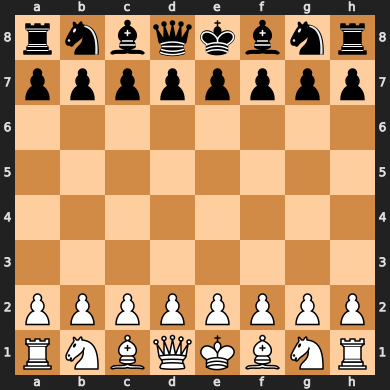

In [3]:
board = chess.Board()
board

## Import the dataset from .csv

In [4]:
games = pd.read_csv('games.csv')

In [5]:
games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
# See the summary stats for numeric variables
games.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


## Cleaning the dataframes

In [7]:
# Check NA's
games.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

It turns out, we don't have any NA's. Now, we would just like to keep the variables that we need

In [8]:
df = games.drop(["id","rated","created_at","last_move_at","white_id","black_id"], axis=1)

Create first move variable for both white and black by splitting the column "moves"

In [9]:
moves = df.moves.str.split(n=2, expand=True)
moves

,0,1,2
0,d4,d5,c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4
1,d4,Nc6,e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ N...
2,e4,e5,d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6...
3,d4,d5,Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O-O O-O...
4,e4,e5,Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 Nf6 Bg5...
...,...,...,...
20053,d4,f5,e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5 d6 Bh...
20054,d4,d6,Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd3 O-O ...
20055,d4,d5,Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 N...
20056,e4,d6,d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 N...


In [10]:
df["w_move1"] = moves[0]
df["b_move1"] = moves[1]

Group the time increment based on Lichess' definition: bullet, blitz, rapid, classical, and custom

In [11]:
df["time_lab"] = my.label(df["increment_code"])

In [12]:
df.head()

,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,w_move1,b_move1,time_lab
0,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,d4,d5,Custom
1,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,d4,Nc6,Custom
2,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,e4,e5,Custom
3,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,d4,d5,Custom
4,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,e4,e5,Custom


## Exploratory Data Analysis (EDA)

First, we would like to see the win rate for white vs black

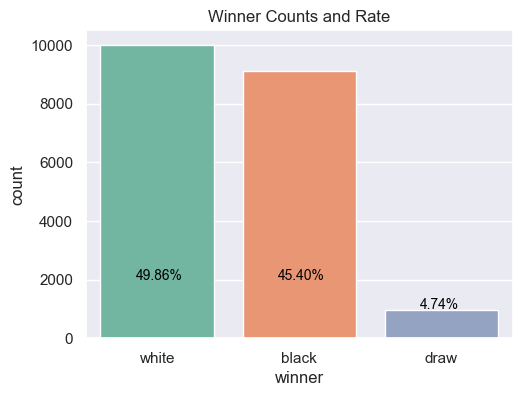

In [13]:
#Calculate win rate
a = df.winner.str.count("white").sum()/len(df)*100
b = df.winner.str.count("black").sum()/len(df)*100
c = 100-a-b

sns.set(rc={'figure.figsize':(5.5, 4)})
sns.countplot(data=df, x='winner', palette='Set2').set(title='Winner Counts and Rate')
plt.annotate("%.2f%%" %(a), xy = (-0.15, 2000),fontsize = 10,
             color = 'black')
plt.annotate("%.2f%%" %(b), xy = (0.85, 2000),fontsize = 10,
             color = 'black')
plt.annotate("%.2f%%" %(c), xy = (1.85, 1000),fontsize = 10,
             color = 'black')

plt.savefig('winnerhist.png', bbox_inches = 'tight')

Apparently, white wins 4.45% more often than black. Now we would like to see if this is due to their rating differences, or perhaps other factor.

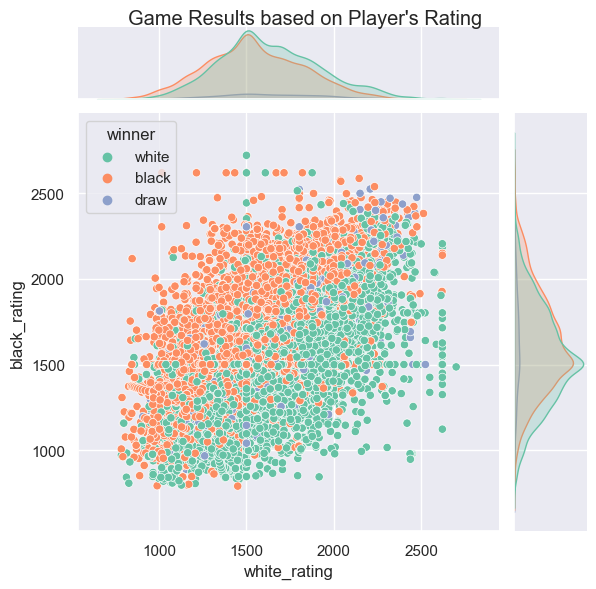

In [14]:
p1=sns.jointplot(x="white_rating", y="black_rating",hue="winner",palette="Set2",data=df)
p1.fig.suptitle("Game Results based on Player's Rating")
p1.fig.subplots_adjust(top=0.95)

plt.savefig('gameres.png', bbox_inches = 'tight')

It seems from the plot above that the game is fair; as rating goes up, the winning rate does too. The higher winning rate of white piece is not due to difference in ratings, it might be due to white being the first one to make a move.

### Opening move(s) and win probability

Since we would like to predict the winner based on the opening move, we first need to analyze how the game result looks like based on the opening move in terms of probability.

In [15]:
df_eco = pd.crosstab(df.opening_eco, columns = df.winner, normalize = 'index')
df_eco.head()

winner,black,draw,white
opening_eco,,,
A00,0.566038,0.038729,0.395233
A01,0.487805,0.048780,0.463415
A02,0.548780,0.060976,0.390244
A03,0.487179,0.128205,0.384615
A04,0.354386,0.098246,0.547368


In [16]:
df["eco_prob"]=df['opening_eco'].map(dict(df_eco['white'])) #white's win prob. based on their opening move
df.isnull().sum()

turns              0
victory_status     0
winner             0
increment_code     0
white_rating       0
black_rating       0
moves              0
opening_eco        0
opening_name       0
opening_ply        0
w_move1            0
b_move1           18
time_lab           0
eco_prob           0
dtype: int64

In [17]:
# Remove NA's
df = df.dropna()

Deal with categorical variables: time increment label and opening_eco

In [18]:
# Make dummies for time increment
df = pd.get_dummies(df, columns=['time_lab'])

### Create the predictors' dataframe

In [19]:
# Remove draw
df2 = df.drop(df[df.winner == "draw"].index)

In [20]:
x = df2.drop(["victory_status","increment_code","moves",
             "opening_eco","opening_name","w_move1","b_move1", "winner"], axis=1)
x.columns

Index(['turns', 'white_rating', 'black_rating', 'opening_ply', 'eco_prob',
       'time_lab_Classical', 'time_lab_Custom', 'time_lab_Rapid'],
      dtype='object')

### Create the response dataframe

In [21]:
# Change the winner var into binary: winner is white=1, black=0
df2.replace({'white' : 1, 'black': 0}, inplace = True)
y = df2.winner
y

0        1
1        0
2        1
3        1
4        1
        ..
20053    1
20054    0
20055    1
20056    1
20057    0
Name: winner, Length: 19090, dtype: int64

### Split the data into train and test

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, stratify = y, random_state=100) #chose the test size to be 20% of the data (pareto)

 # Logistic Regression

In [24]:
mod1 = LogisticRegression(class_weight= 'balanced', max_iter = 1000)

In [25]:
mod1.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [26]:
ypred_mod1 = mod1.predict(x_test)

#Print the accuracy score
print("The accuracy of Logistic Regression is %.2f%%" %(round(mod1.score(x_test,y_test)*100,2)))

The accuracy of Logistic Regression is 65.22%


In [27]:
#Print the classification report
print(classification_report(y_test, ypred_mod1))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1821
           1       0.67      0.65      0.66      1997

    accuracy                           0.65      3818
   macro avg       0.65      0.65      0.65      3818
weighted avg       0.65      0.65      0.65      3818



In [28]:
prob_mod1 = mod1.predict_proba(x_test) #return the probability of win/lose

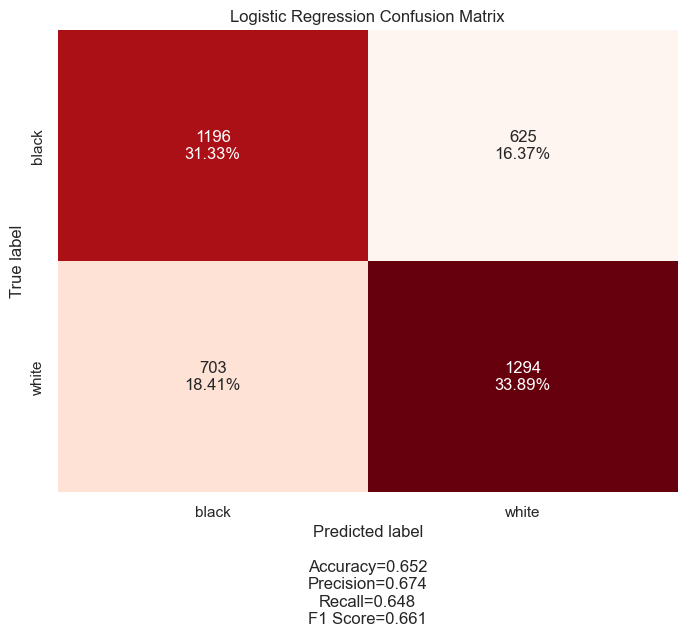

In [29]:
# Confusion Matrix
cf_mod1 = confusion_matrix(y_test, ypred_mod1)
my.make_confusion_matrix(cf_mod1, figsize=(8,6), cbar=False, categories = ["black","white"], cmap="Reds", title = "Logistic Regression Confusion Matrix")
plt.savefig('cf_mod1.png', bbox_inches = 'tight')

# K-NN Classification

In [30]:
mod2 = KNeighborsClassifier(n_neighbors = 5)

In [31]:
mod2.fit(x_train,y_train)

KNeighborsClassifier()

In [32]:
ypred_mod2 = mod2.predict(x_test)

#Print the accuracy score
print("The accuracy of k-Neighbors Classifier is %.2f%%" %(round(mod2.score(x_test,y_test)*100,2)))

The accuracy of k-Neighbors Classifier is 62.52%


In [33]:
#Print the classification report
print(classification_report(y_test, ypred_mod2))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1821
           1       0.64      0.66      0.65      1997

    accuracy                           0.63      3818
   macro avg       0.62      0.62      0.62      3818
weighted avg       0.62      0.63      0.62      3818



In [34]:
prob_mod2 = mod2.predict_proba(x_test)

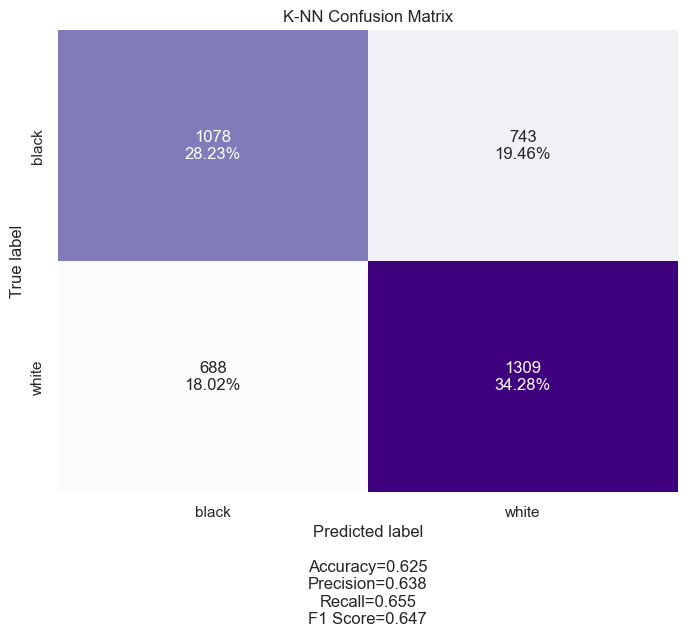

In [35]:
# Confusion Matrix
cf_mod2 = confusion_matrix(y_test, ypred_mod2)
my.make_confusion_matrix(cf_mod2, figsize=(8,6), cbar=False, categories = ["black","white"], cmap="Purples", title = "K-NN Confusion Matrix")
plt.savefig('cf_mod2.png', bbox_inches = 'tight')

# Decision Tree

In [36]:
mod3 = DecisionTreeClassifier()

In [37]:
mod3.fit(x_train,y_train)

DecisionTreeClassifier()

In [38]:
ypred_mod3 = mod3.predict(x_test)

#Print the accuracy score
print("The accuracy of decision tree is %.2f%%" %(round(mod3.score(x_test,y_test)*100,2)))

The accuracy of decision tree is 62.00%


In [39]:
#Print the classification report
print(classification_report(y_test, ypred_mod3))

              precision    recall  f1-score   support

           0       0.60      0.61      0.61      1821
           1       0.64      0.63      0.63      1997

    accuracy                           0.62      3818
   macro avg       0.62      0.62      0.62      3818
weighted avg       0.62      0.62      0.62      3818



In [40]:
prob_mod3 = mod3.predict_proba(x_test)

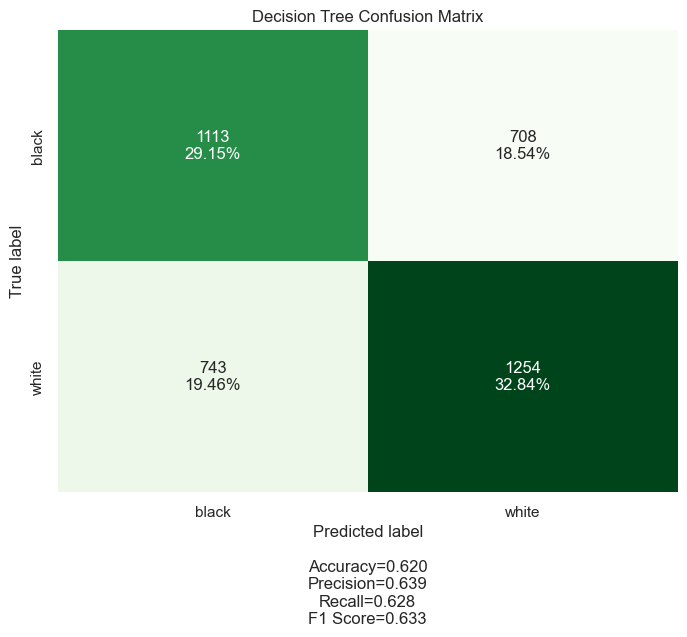

In [41]:
# Confusion Matrix
cf_mod3 = confusion_matrix(y_test, ypred_mod3)
my.make_confusion_matrix(cf_mod3, figsize=(8,6), cbar=False, categories = ["black","white"], cmap="Greens", title = "Decision Tree Confusion Matrix")
plt.savefig('cf_mod3.png', bbox_inches = 'tight')

# Goodness-of-Fit Test: ROC Curve

In [42]:
FP1, TP1, T1 = roc_curve(y_test, prob_mod1[:,1], pos_label=1)
FP2, TP2, T2 = roc_curve(y_test, prob_mod2[:,1], pos_label=1)
FP3, TP3, T3 = roc_curve(y_test, prob_mod3[:,1], pos_label=1)

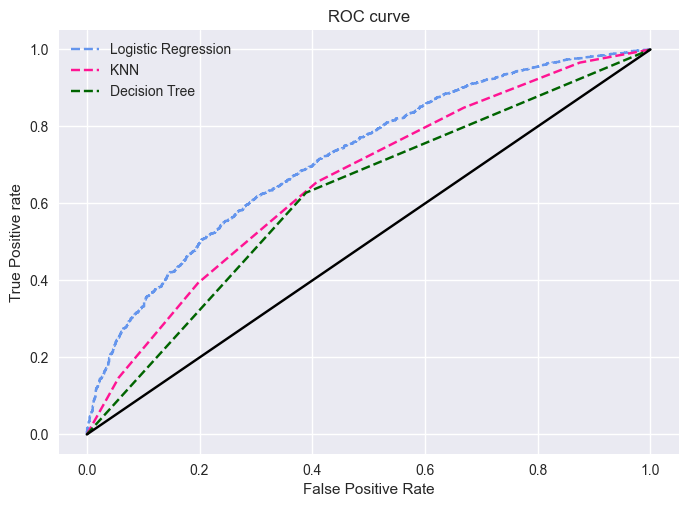

In [43]:
plt.style.use('seaborn')

# Plot ROC
plt.plot(FP1, TP1, linestyle='--',color='cornflowerblue', label='Logistic Regression')
plt.plot(FP2, TP2, linestyle='--',color='deeppink', label='KNN')
plt.plot(FP3, TP3, linestyle='--',color='darkgreen', label='Decision Tree')
plt.plot([0, 1], [0, 1], color = 'black')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC.png')

In [45]:
auc_mod1 = roc_auc_score(y_test, prob_mod1[:,1])
auc_mod2 = roc_auc_score(y_test, prob_mod2[:,1])
auc_mod3 = roc_auc_score(y_test, prob_mod3[:,1])

print(auc_mod1,auc_mod2,auc_mod3)

0.7192906328190803 0.6588670760121512 0.6195722743918184


In [46]:
print("The highest AUC is", round(max(auc_mod1,auc_mod2,auc_mod3),2), "achieved by Logistic Regression")

The highest AUC is 0.72 achieved by Logistic Regression


# Stockfish Win Metric

The overall accuracy of these models are slightly above average, all scored below 70%. We would like a better way to predict the winner, by creating a metric that calculates the win probability using Stockfish. If the player made similar moves to Stockfish then they were playing optimally.

In [47]:
df.new = games.drop(["rated","created_at","last_move_at","turns","victory_status",
                    "increment_code", "opening_eco", "opening_name", "opening_ply"], axis=1)

C:\Users\Stephanie Tanasia\AppData\Local\Temp\ipykernel_664\4134471972.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.new = games.drop(["rated","created_at","last_move_at","turns","victory_status",


In [48]:
df.new['moves_list'] = df.new.moves.apply(lambda x: x.split())

In [52]:
df.new['white_win'] = np.where(df.new['winner'] == 'White', 1, 0)
df.new.head()

,id,winner,white_id,white_rating,black_id,black_rating,moves,moves_list,white_win
0,TZJHLljE,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",0
1,l1NXvwaE,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",0
2,mIICvQHh,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",0
3,kWKvrqYL,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",0
4,9tXo1AUZ,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",0


The metric is built as a function, under the name of stockfish_metric. It compares the move the user does for every board position and compare it to the top N moves that Stockfish does. The win metric is = # of similar moves / # of all moves.

In [81]:
tes2 = df.new.iloc[0:3,7]

In [98]:
# Let's try the metric with the top 5 moves
my.stockfish_metric(tes2,5) 

([0.7142857142857143, 0.375, 0.5806451612903226],
 [0.3333333333333333, 0.625, 0.43333333333333335])

In [99]:
# What about 3 moves?
my.stockfish_metric(tes2,3) 

([0.7142857142857143, 0.375, 0.5806451612903226],
 [0.3333333333333333, 0.625, 0.43333333333333335])

### How good is this metric??

There's a parameter to be decided, which is the # of moves to compare with user's moves. The author tried 3 moves vs 5 moves and there was no difference. To save time (and also because my laptop's fan sounds like it's going to fly away), we will use the top 3 moves. If we decrease this number, the metric becomes stricter.

In [93]:
# Run the function over 100 rows
fish_result = my.stockfish_metric(df.new.iloc[0:99,7],3)

In [94]:
# Insert W_rate and B_rate in df.new
df.trymetric = df.new.iloc[0:99,]
df.trymetric["W_rate"] = fish_result[0]
df.trymetric["B_rate"] = fish_result[1]

C:\Users\Stephanie Tanasia\AppData\Local\Temp\ipykernel_664\1180984005.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.trymetric = df.new.iloc[0:99,]


In [95]:
# Create metric_winner out of metric
metric_winner=[]
for i in range(len(df.trymetric)):
    if df.trymetric["W_rate"].iloc[i] > df.trymetric["B_rate"].iloc[i]:
        metric_winner.append("white")
    elif df.trymetric["W_rate"].iloc[i] == df.trymetric["B_rate"].iloc[i]:
        metric_winner.append("draw")
    else:
        metric_winner.append("black")

df.trymetric["metric_winner"] = metric_winner

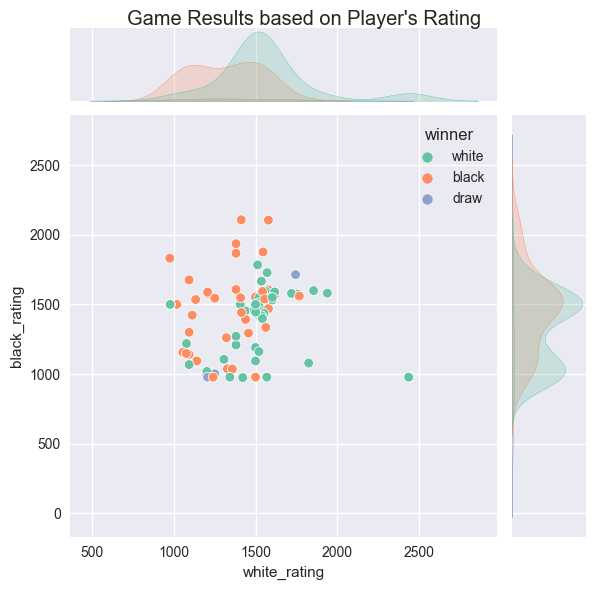

In [158]:
# Rating differences between players
pm=sns.jointplot(x="white_rating", y="black_rating",hue="winner",palette="Set2",data=df.trymetric)
pm.fig.suptitle("Game Results based on Player's Rating")
pm.fig.subplots_adjust(top=0.95)

plt.savefig('rating_metrictrial.png')

In [97]:
# Compare with winner
num = 0
for i in range(len(df.trymetric)):
    if df.trymetric["metric_winner"].iloc[i] == df.trymetric["winner"].iloc[i]:
        num = num + 1
print(num/100)

0.61


Pretty good! If we increase the number of moves compared and also the sample size, we will get a better result.

In [149]:
conf_matrix = confusion_matrix(df.trymetric["winner"], df.trymetric["metric_winner"], labels = ["white", "black", "draw"])

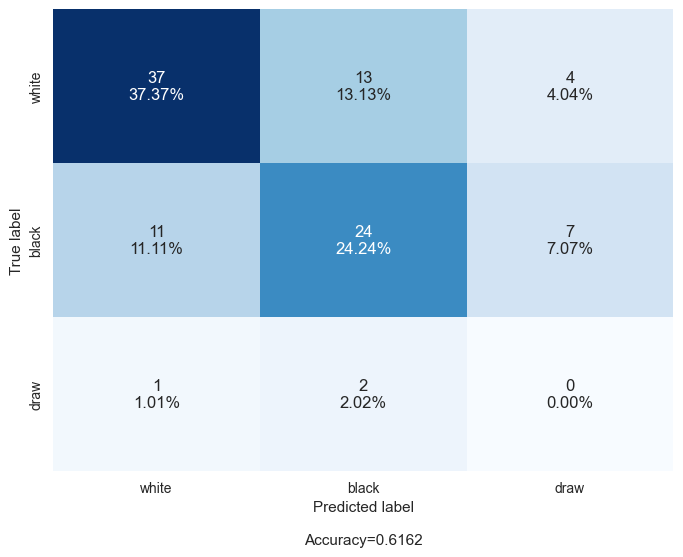

In [155]:
cat = ["white", "black", "draw"]
my.make_confusion_matrix(conf_matrix, figsize=(8,6), cbar=False, categories = cat)
plt.savefig('cf_matrix.png', bbox_inches = 'tight')